Using the car price dataset 

We'll keep working with the `MSRP` variable, and we'll transform it to a classification task. 

### Features

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`,
* `MSRP`

In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
%matplotlib inline

data = pd.read_csv('../data/car_prices.csv')
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

In [330]:
data = data[
    [
        'make',
        'model',
        'year',
        'engine_hp',
        'engine_cylinders',
        'transmission_type',
        'vehicle_style',
        'highway_mpg',
        'city_mpg',
        'msrp'
    ]
]

data.isna().sum()
data['engine_hp'].fillna(0, inplace=True)
data['engine_cylinders'].fillna(0, inplace=True)
# df['year'] = pd.to_numeric(df['year'], errors='coerce')
# df['engine_hp'] = pd.to_numeric(df['engine_hp'], errors='coerce')
# df['city_mpg'] = pd.to_numeric(df['city_mpg'], errors='coerce')

df = data.copy()

### Question 1

What is the most frequent observation (mode) for the column `transmission_type`?

- `AUTOMATIC`
- `MANUAL`
- `AUTOMATED_MANUAL`
- `DIRECT_DRIVE`


In [331]:
df['transmission_type'].value_counts()

AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: transmission_type, dtype: int64


### Question 2

Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your dataset. 
In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

- `engine_hp` and `year`
- `engine_hp` and `engine_cylinders`
- `highway_mpg` and `engine_cylinders`
- `highway_mpg` and `city_mpg`

In [332]:
int_columns = list(df.dtypes[ df.dtypes == (int)].index)
float_columns = list(df.dtypes[ df.dtypes == (float)].index)
# df.dtypes
numeric_columns = int_columns + float_columns
numeric_df  = df[numeric_columns]
numeric_df.describe()
numeric_df.corr()

,year,highway_mpg,city_mpg,msrp,engine_hp,engine_cylinders
year,1.000000,0.258240,0.198171,0.227590,0.338714,-0.040708
highway_mpg,0.258240,1.000000,0.886829,-0.160043,-0.415707,-0.614541
city_mpg,0.198171,0.886829,1.000000,-0.157676,-0.424918,-0.587306
msrp,0.227590,-0.160043,-0.157676,1.000000,0.650095,0.526274
engine_hp,0.338714,-0.415707,-0.424918,0.650095,1.000000,0.774851
engine_cylinders,-0.040708,-0.614541,-0.587306,0.526274,0.774851,1.000000


year              year                1.000000
highway_mpg       city_mpg            0.886829
engine_cylinders  engine_hp           0.774851
engine_hp         msrp                0.650095
engine_cylinders  msrp                0.526274
year              engine_hp           0.338714
highway_mpg       year                0.258240
year              msrp                0.227590
                  city_mpg            0.198171
                  engine_cylinders   -0.040708
city_mpg          msrp               -0.157676
highway_mpg       msrp               -0.160043
engine_hp         highway_mpg        -0.415707
city_mpg          engine_hp          -0.424918
                  engine_cylinders   -0.587306
highway_mpg       engine_cylinders   -0.614541
dtype: float64

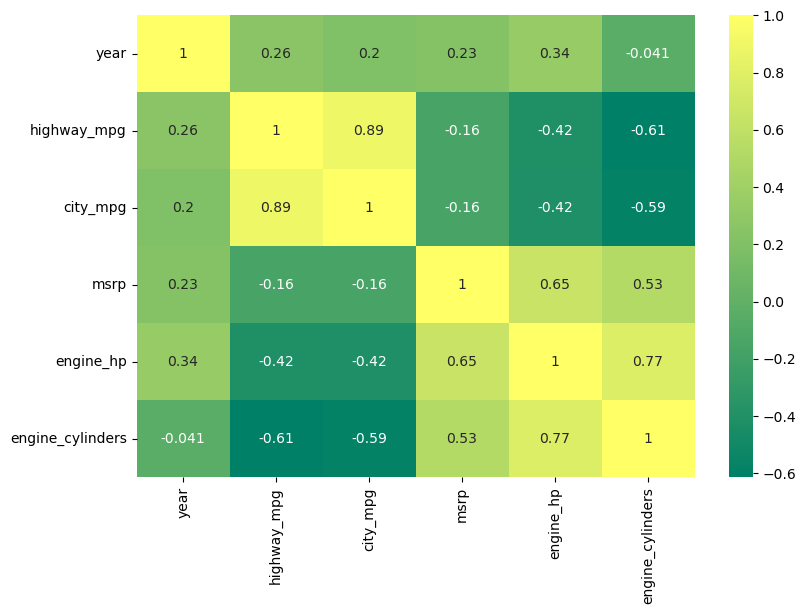

In [333]:
plt.figure(figsize=(9, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='summer')
numeric_df.corr().unstack().sort_values(ascending=False).drop_duplicates()


### Make `price` binary

* Now we need to turn the `price` variable from numeric into a binary format.
* Let's create a variable `above_average` which is `1` if the `price` is above its mean value and `0` otherwise.


In [334]:
mean_price = df['msrp'].mean()
df['above_average'] = (df['msrp'] > mean_price).astype(int)
df['above_average'].value_counts(normalize=True)
df = df.drop(['msrp'], axis=1)


### Split the data

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value (`above_average`) is not in your dataframe.

In [335]:
# split data into train/val/test sets
df_train_full, df_test = train_test_split(df, test_size=0.4, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)
assert len(df) == (len(df_train_full) + len(df_val) + len(df_test))

df_train_full = df_train_full.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train_full['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values



### Question 3

* Calculate the mutual information score between `above_average` and other categorical variables in our dataset. 
  Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

Which of these variables has the lowest mutual information score?
  
- `make`
- `model`
- `transmission_type`
- `vehicle_style`


In [336]:
def calc_mutual_information(series):
    return mutual_info_score(series, df_train_full['above_average'])

for col in df_train_full.columns[df_train_full.dtypes == 'object']:
    print(col, calc_mutual_information(df_train_full[col]).round(2))

make 0.24
model 0.46
transmission_type 0.02
vehicle_style 0.08


In [337]:
df_train_full = df_train_full.drop(['above_average'], axis=1)
df_test = df_test.drop(['above_average'], axis=1)
df_val = df_val.drop(['above_average'], axis=1)


### Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.60
- 0.72
- 0.84
- 0.95

In [338]:
#train a logistic regression
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train_full.to_dict(orient='records'))
dv.get_feature_names_out()
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

# Calculate the accuracy on the validation dataset and round it to 2 decimal digits.
model.fit(X_train, y_train)



LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [339]:
X_val = dv.transform(df_val.to_dict(orient='records'))
y_pred = model.predict(X_val)
accuracy = np.round(accuracy_score(y_val, y_pred), 2)
accuracy

0.94

### Question 5 

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

Which of following feature has the smallest difference?

- `year`
- `engine_hp`
- `transmission_type`
- `city_mpg`

> **Note**: the difference doesn't have to be positive

In [340]:
# Let's find the least useful feature using the *feature elimination* technique. 

scores = {}
for feature in df_train_full.columns:
    df_train_small = df_train_full.drop([feature], axis=1)
    X_train = dv.fit_transform(df_train_small.to_dict(orient='records'))
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    X_val = dv.transform(df_val.to_dict(orient='records'))
    y_pred = model.predict(X_val)
    new_accuracy = accuracy_score(y_val, y_pred)
    scores[feature] = {
        'score': new_accuracy,
        'diff_from_original': accuracy - new_accuracy
    }
    
scores_df = pd.DataFrame(scores).T
# select only the feature row where the first column is in ['engine_hp', 'year', 'transmission_type', 'city_mpg']
scores_df = scores_df.loc[['engine_hp', 'year', 'transmission_type', 'city_mpg']]
scores_df.sort_values(by='diff_from_original', ascending=True)

,score,diff_from_original
year,0.951322,-0.011322
city_mpg,0.950063,-0.010063
transmission_type,0.935795,0.004205
engine_hp,0.934117,0.005883


### Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn.
* We'll need to use the original column `price`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model on the training data with a solver `'sag'`. Set the seed to `42`.
* This model also has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`.
* Round your RMSE scores to 3 decimal digits.

Which of these alphas leads to the best RMSE on the validation set?

- 0
- 0.01
- 0.1
- 1
- 10

> **Note**: If there are multiple options, select the smallest `alpha`.



In [341]:
data['msrp'] = data['msrp'].apply(np.log1p)
df_train_full, df_test = train_test_split(data, test_size=0.4, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)

df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train_full = df_train_full.reset_index(drop=True)

y_train = df_train_full['msrp'].values
y_val = df_val['msrp'].values
y_test = df_test['msrp'].values

del df_train_full['msrp']
del df_val['msrp']
del df_test['msrp']

y_train.shape, y_val.shape, y_test.shape

((7148,), (2383,), (2383,))

In [342]:
dv = DictVectorizer(sparse=False)
train_dict = df_train_full.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)



In [343]:
scores = {}
for alpha in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=alpha, solver='sag', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    score = mean_squared_error(y_val, y_pred, squared=False)
    scores[alpha] = round(score, 3)
    print(f'alpha = {alpha}:\t RMSE = {score}', round(score, 3))
    
min(scores.values())

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha = 0:	 RMSE = 0.4853266592873395 0.485


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha = 0.01:	 RMSE = 0.4853268536521661 0.485


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha = 0.1:	 RMSE = 0.48532860292453234 0.485


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha = 1:	 RMSE = 0.48534609194113665 0.485
alpha = 10:	 RMSE = 0.48552060825297355 0.486


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.485